<img src="https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/logoFIUBA.jpg" width="500" align="center">


# Series Temporales
### Sergio Hinojosa


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from sklearn.metrics import mean_squared_error

## Dataset

Ventas al mercado interno de Producción Nacional de Vino en miles de hectolitros. Base 1994

In [2]:
dataset = pd.read_csv('dataset/ventas-al-mercado-interno-vitivinicola-base-1994-valores-mensuales.csv')
dataset.head()

,indice_tiempo,vino
0,1994-01-01,1055.0
1,1994-02-01,1029.0
2,1994-03-01,1214.0
3,1994-04-01,1193.0
4,1994-05-01,1235.0


Cantidad de muestras y tipo de datos:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   indice_tiempo  362 non-null    object 
 1   vino           322 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


Convierto el tipo de dato del indice de tiempo al tipo datetime.

In [4]:
dataset["indice_tiempo"]=pd.to_datetime(dataset["indice_tiempo"], format='%Y-%m-%d')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   indice_tiempo  362 non-null    datetime64[ns]
 1   vino           322 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


### Valores nulos

In [5]:
nan_rows = dataset[dataset.isnull().any(axis=1)]
print(len(nan_rows))

40


In [6]:
print(nan_rows)

    indice_tiempo  vino
322    2020-11-01   NaN
323    2020-12-01   NaN
324    2021-01-01   NaN
325    2021-02-01   NaN
326    2021-03-01   NaN
327    2021-04-01   NaN
328    2021-05-01   NaN
329    2021-06-01   NaN
330    2021-07-01   NaN
331    2021-08-01   NaN
332    2021-09-01   NaN
333    2021-10-01   NaN
334    2021-11-01   NaN
335    2021-12-01   NaN
336    2022-01-01   NaN
337    2022-02-01   NaN
338    2022-03-01   NaN
339    2022-04-01   NaN
340    2022-05-01   NaN
341    2022-06-01   NaN
342    2022-07-01   NaN
343    2022-08-01   NaN
344    2022-09-01   NaN
345    2022-10-01   NaN
346    2022-11-01   NaN
347    2022-12-01   NaN
348    2023-01-01   NaN
349    2023-02-01   NaN
350    2023-03-01   NaN
351    2023-04-01   NaN
352    2023-05-01   NaN
353    2023-06-01   NaN
354    2023-07-01   NaN
355    2023-08-01   NaN
356    2023-09-01   NaN
357    2023-10-01   NaN
358    2023-11-01   NaN
359    2023-12-01   NaN
360    2024-01-01   NaN
361    2024-02-01   NaN


Los valores nulos corresponden a los ultimos 40 meses. Elimino estos indices de tiempo:

In [7]:
dataset = dataset[dataset["indice_tiempo"] < '2020-11-01']

nan_rows = dataset[dataset.isnull().any(axis=1)]
print(len(nan_rows))

0


Ya no hay valores faltantes.

### Gráfica del dataset

Text(0, 0.5, 'Ventas (hectolitros)')

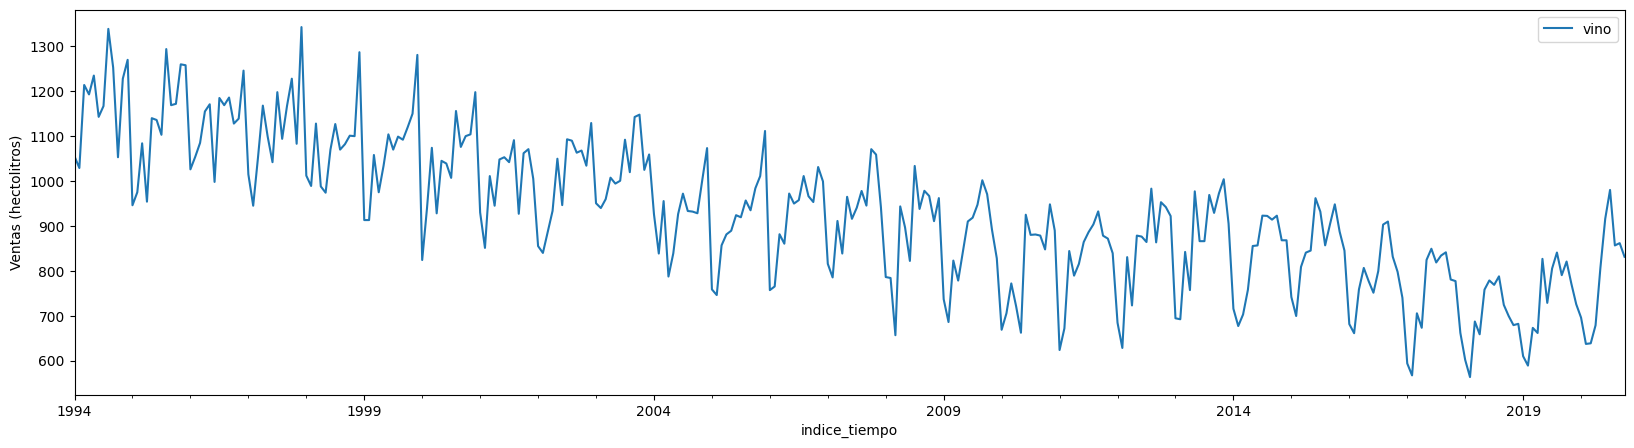

In [8]:
dataset.plot(x = 'indice_tiempo', y = 'vino', figsize=(20, 5))
plt.ylabel("Ventas (hectolitros)")

In [9]:
dataset.describe()

,indice_tiempo,vino
count,322,322.000000
mean,2007-05-17 09:14:32.049689344,927.463452
min,1994-01-01 00:00:00,563.160000
25%,2000-09-08 12:00:00,823.027603
50%,2007-05-16 12:00:00,928.091000
75%,2014-01-24 06:00:00,1044.250000
max,2020-10-01 00:00:00,1343.000000
std,NaN,160.407668


In [10]:
fechas_description = dataset.agg(min=('indice_tiempo', np.min), max=('indice_tiempo', np.max))
fechas_description

,indice_tiempo
min,1994-01-01
max,2020-10-01


El intervalo de tiempo medido es de el 1/1/1994 al 1/10/2020, una medición por mes.

Se observa un comportamiento ciclico con período de un año, se hace más evidente en los últimos años.

Se puede observar también una tendencia decreciente, a primera vista lineal.

### Observación de 5 años

Para observar mejor los ciclos, se toma de muestra 5 años:

<Axes: xlabel='indice_tiempo'>

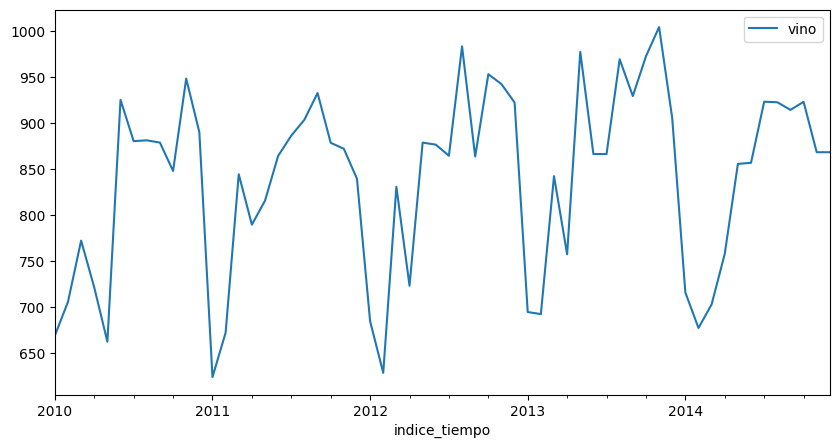

In [11]:
dataset_year = dataset[dataset["indice_tiempo"] < '2015-1-1']
dataset_year = dataset_year[dataset_year["indice_tiempo"] > '2009-12-31']

dataset_year.plot(x = 'indice_tiempo', y = 'vino', figsize=(10, 5))

Se puede apreciar que el comportamiento ciclico se da anualmente, siendo los meses de menos ventas en los 2 primeros meses y los máximos a finales de año.  

Un ciclo cuenta con 12 muestras, extrayendo uno de ejemplo se ve como el siguiente gráfico:  

<Axes: xlabel='indice_tiempo'>

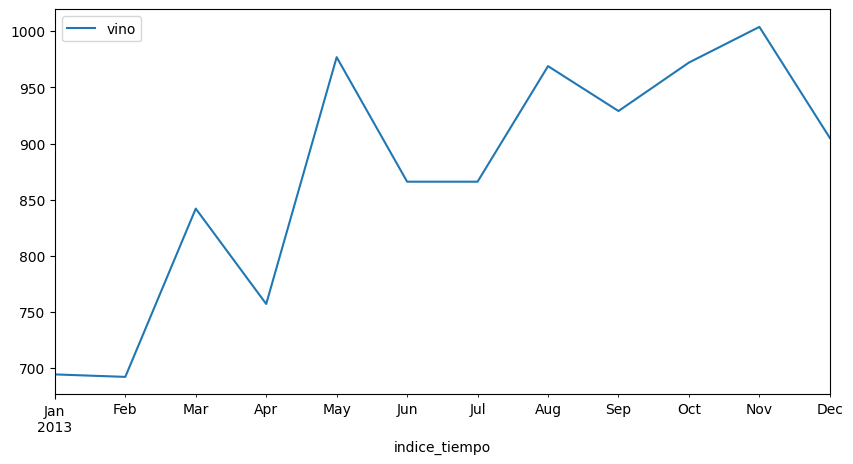

In [12]:
dataset_year = dataset[dataset["indice_tiempo"] < '2014-1-1']
dataset_year = dataset_year[dataset_year["indice_tiempo"] > '2012-12-31']

dataset_year.plot(x = 'indice_tiempo', y = 'vino', figsize=(10, 5))

### Descomposición de la serie usando el modelo aditivo de 4 componentes

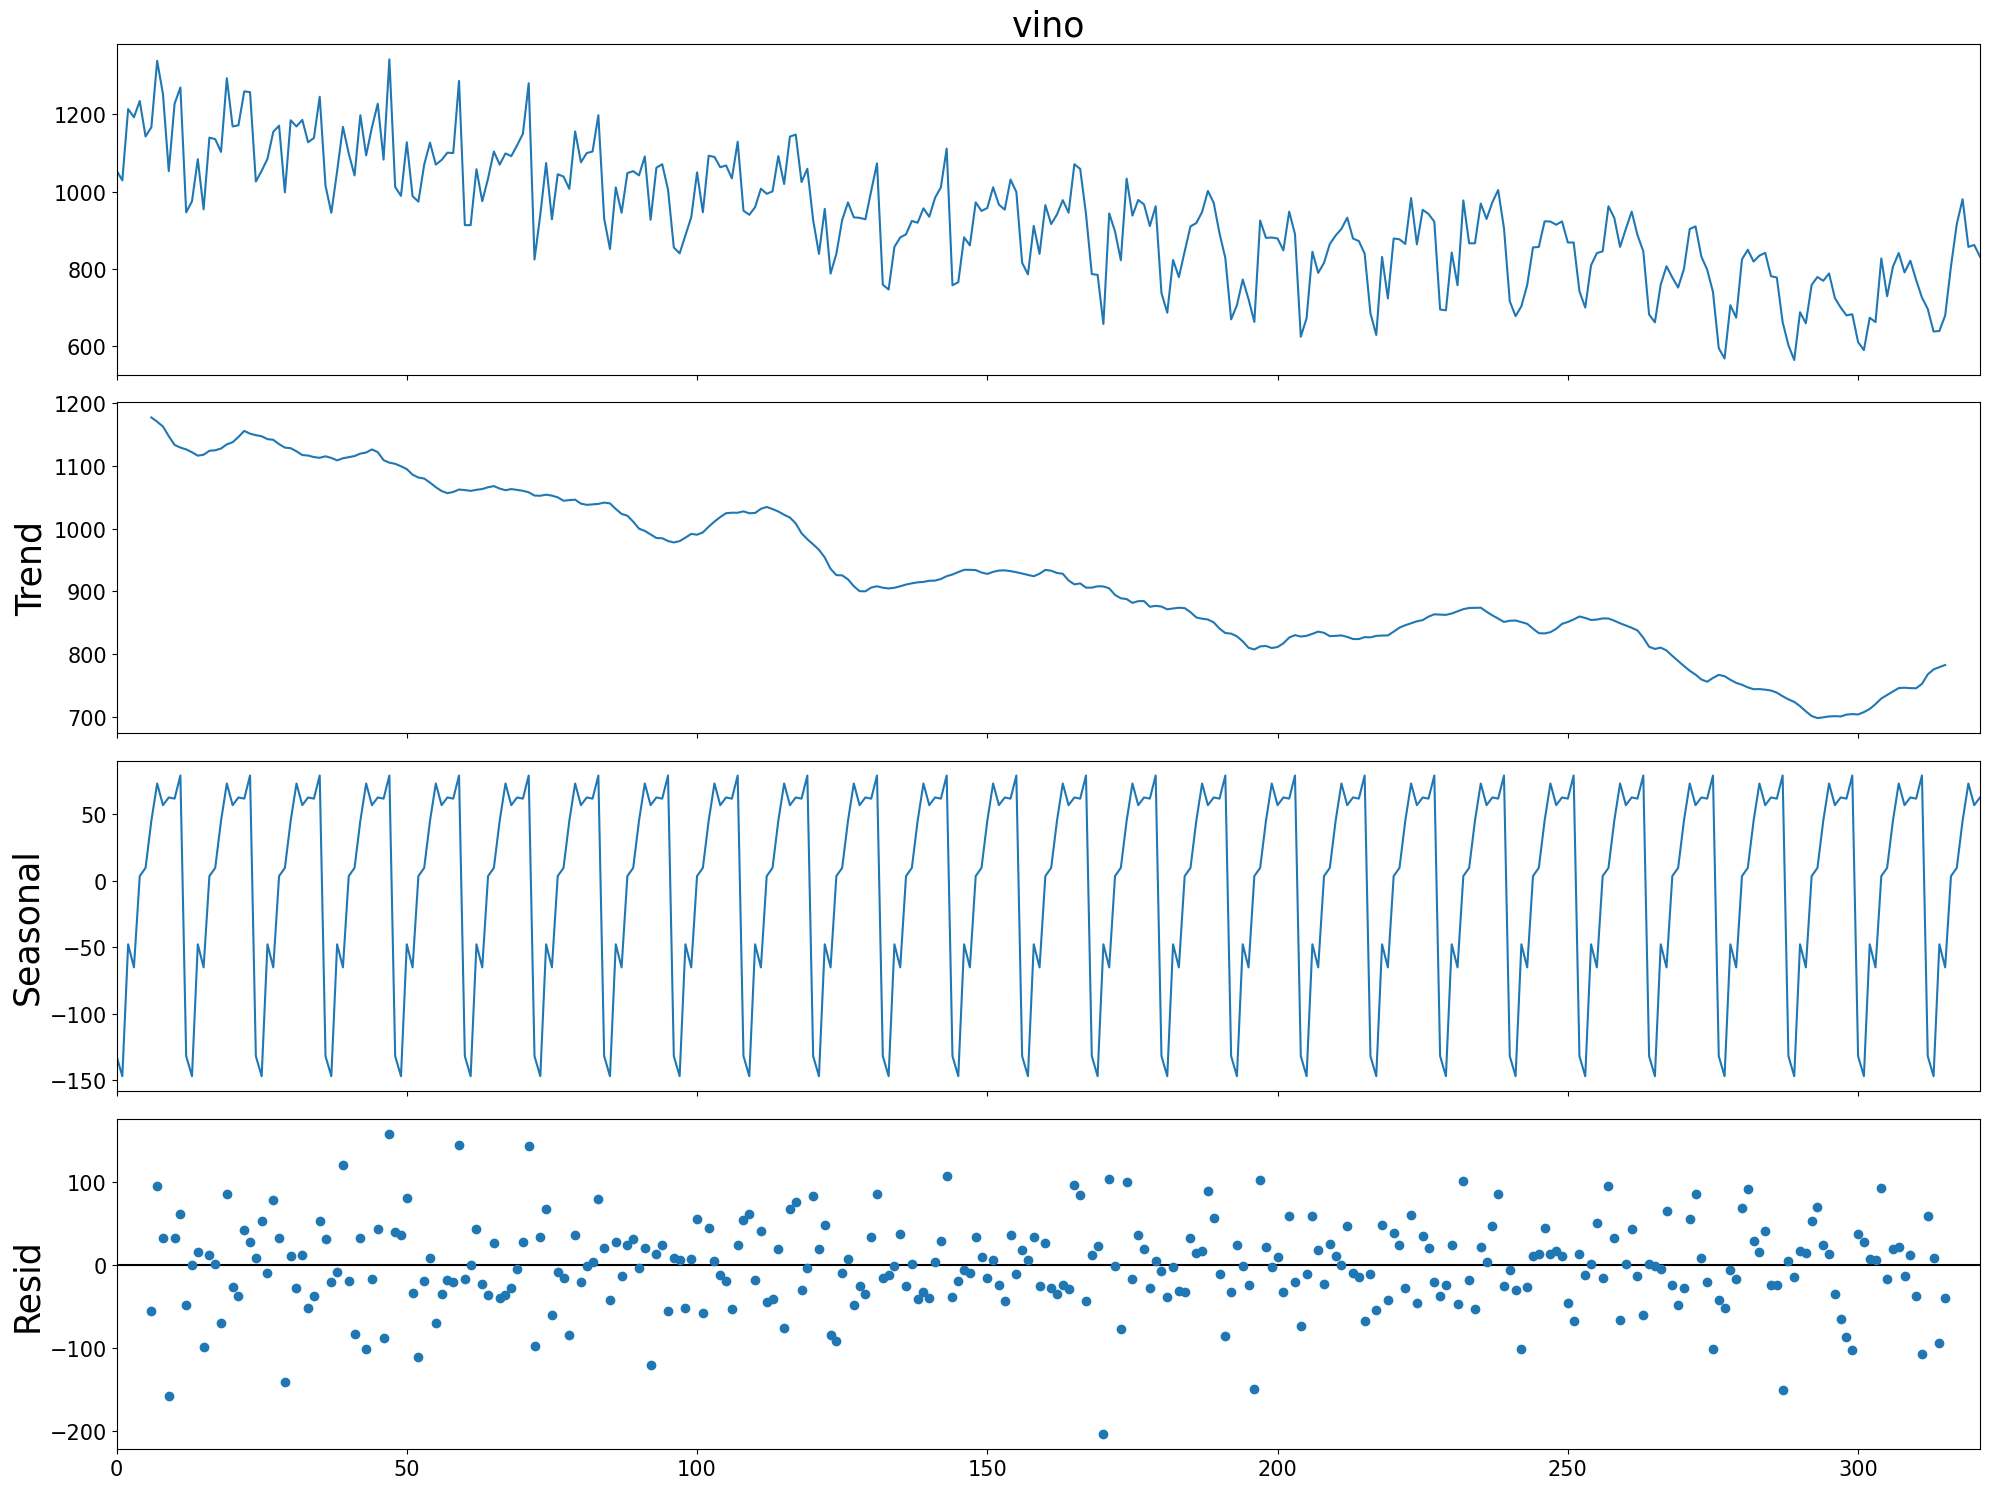

In [13]:
#Aditiva
params = {'axes.labelsize': 25,
              'axes.titlesize': 25,
              'figure.figsize': (20,15),
              'xtick.labelsize': 15,
              'ytick.labelsize': 15}
plt.rcParams.update(params)
decomposition_add = sm.tsa.seasonal_decompose(dataset['vino'], model='additive',period=12)

decomposition_add.plot()
plt.show()

## Preprocesamiento

Lo que se puede observar a simple viste es que la media no es constante y la covarianza podría ser constante.  
Se probara algunas transformaciones para poder quitar la tendencia decreciente buscando una media constante y poder evaluar la covarianza a tra vez de la correlación.

#### Diferenciación
Para eliminar la tendencia lineal se realizará la trasformación de diferenciación:

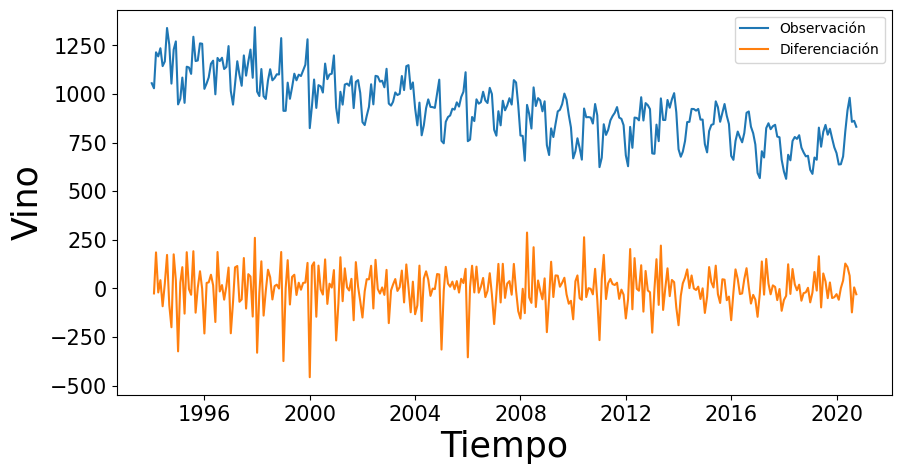

In [14]:
ndiff = 1
diff = dataset['vino'].diff(ndiff)

# GRAFICO
plt.figure(figsize=(10, 5))

# Serie original
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')

# Serie diferenciada
plt.plot(dataset['indice_tiempo'], diff, label='Diferenciación')
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Vino")
plt.show()

Diferenciando la serie se pudo eliminar la tendencia decreciente.

Para testear la estacionareidad se puede ver como se comportan los coeficientes autocorrelación:

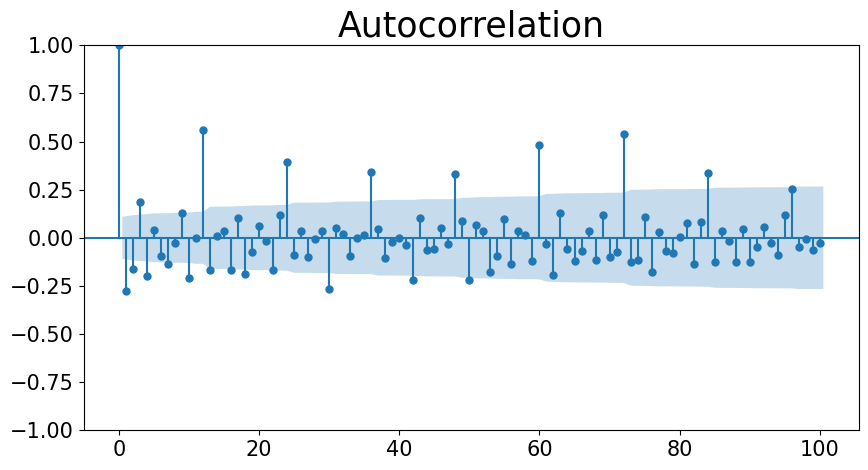

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(diff[ndiff:], lags=100, ax=ax)
plt.show()

Se puede observar que no hay una caída de los valores de los coeficientes, esto nos podría indicar no estacionareidad. También se ven componentes estacionales, en los componentes multiplo de 12.  

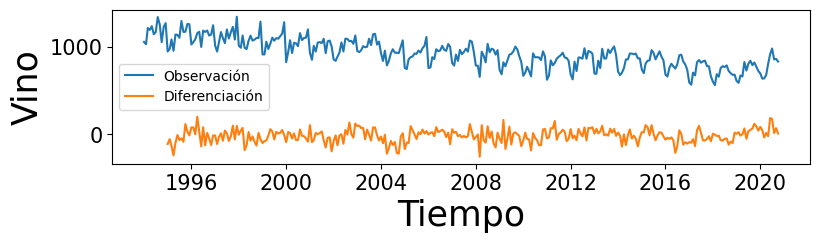

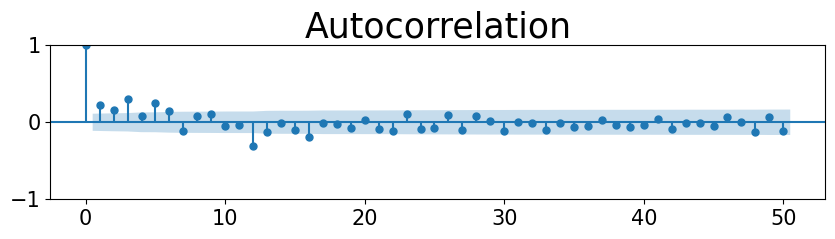

In [16]:
ndiff = 12
diff = dataset['vino'].diff(ndiff)

# GRAFICO
plt.figure(figsize=(9, 2))

# Serie original
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')

# Serie diferenciada
plt.plot(dataset['indice_tiempo'], diff, label='Diferenciación')
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Vino")
plt.show()
fig, ax = plt.subplots(figsize=(10,2))
plot_acf(diff[ndiff:], lags=50, ax=ax)
plt.show()

Por otro lado si bien la diferenciación quita la tendencia decreciente bastante bien, introduce un comportamiento que no es nativo de la serie original. En este caso que la tendencia parece bastante lineal es mejor opción encontrar el tendencia por cuadrados minimos y restarla a la serie.

### Tendencia determinística - Aproximación por cuadrados mínimos

In [17]:
# Transformo los datos de tipo DateTime a números flotantes, porque sino curve_fit no funciona.
ts = np.array([t.timestamp() for t in dataset.indice_tiempo])

##### Tendencia lineal

In [18]:
# Función objetivo.
def objective(x, a, b):
	return a * x + b

#Fiteo la curva.
parameters, covariance = curve_fit(objective, ts, dataset['vino'])

#Muestro los parámetros.
a, b = parameters
print ("Parámetros:",parameters)
print('Modelo: y = %.8f * x + %.8f' % (a, b))

Parámetros: [-5.1242089e-07  1.5318092e+03]
Modelo: y = -0.00000051 * x + 1531.80920199


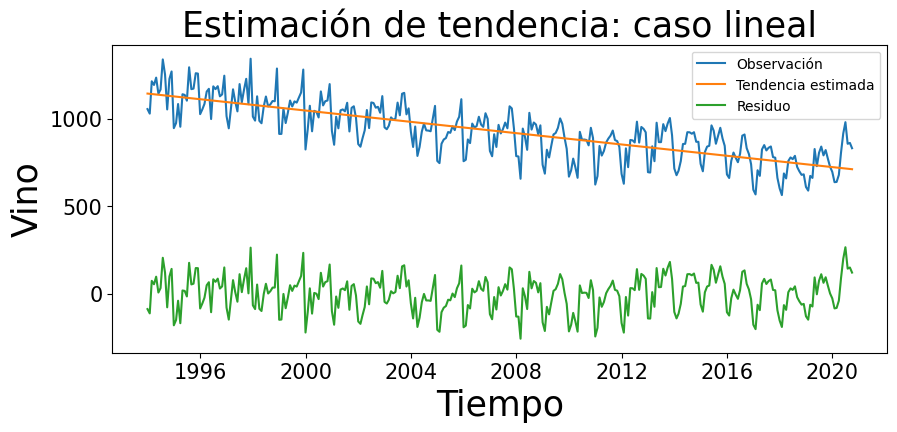

In [19]:
# GRAFICO
plt.figure(figsize=(10, 4))

# Serie original
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')

# Estimación de la tendencia.
plt.plot(dataset['indice_tiempo'], objective(ts, *parameters), label='Tendencia estimada')

# Residuo. Original - Tendencia
residuo = dataset['vino'] - objective(ts, *parameters)
plt.plot(dataset['indice_tiempo'], residuo, label='Residuo')
plt.title("Estimación de tendencia: caso lineal")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Vino")
plt.show()

### Tendencia cuadratica

In [20]:
# Función objetivo.
def objective(x, a, b, c):
	return a*x + b*x*x + c

#Fiteo la curva.
parameters, covariance = curve_fit(objective, ts, dataset['vino'])

#Muestro los parámetros.
a, b, c = parameters
print ("Parámetros:",parameters)
print('Modelo: y = %.8f * x + %.8f * x*x + %.8f' % (a, b, c))

Parámetros: [-1.19420380e-06  2.89040265e-16  1.91658194e+03]
Modelo: y = -0.00000119 * x + 0.00000000 * x*x + 1916.58193845


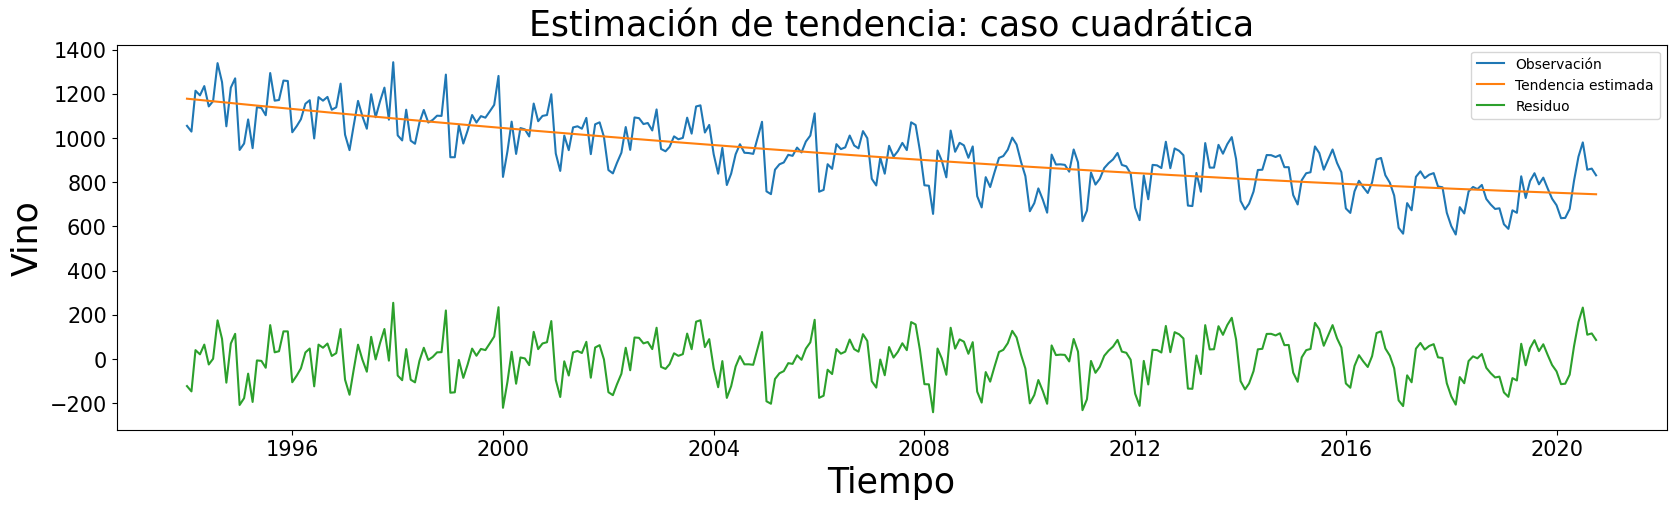

In [21]:
# GRAFICO
plt.figure(figsize=(20, 5))

# Serie original
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')

# Estimación de la tendencia.
plt.plot(dataset['indice_tiempo'], objective(ts, *parameters), label='Tendencia estimada')

# Residuo. Original - Tendencia
residuo = dataset['vino'] - objective(ts, *parameters)
plt.plot(dataset['indice_tiempo'], residuo, label='Residuo')
plt.title("Estimación de tendencia: caso cuadrática")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Vino")
plt.show()

No se observa demasiada diferencia respecto a la tendencia lineal

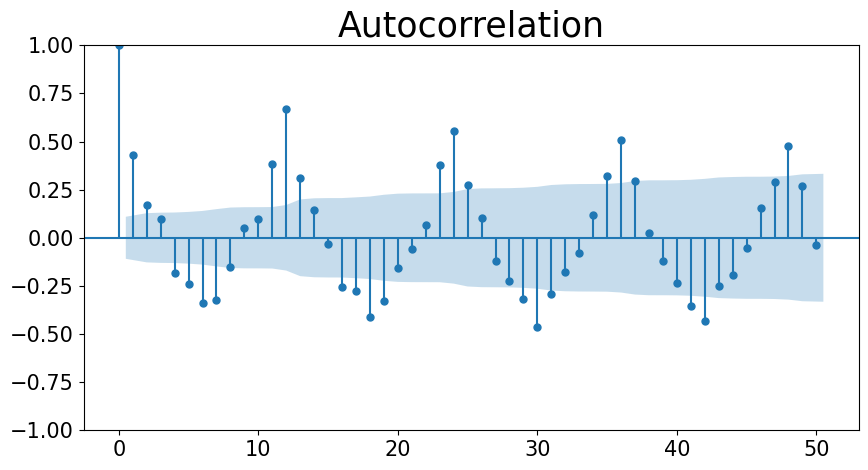

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(residuo, lags=50, ax=ax)
plt.show()

Se observa una periodicidad y un decrecimiento exponencial muy lento.  

Se infiere que aunque se suprima la tendencia lineal o cuadratica continúa siendo NO estacionaria según lo que se observa hasta aquí.  

## Caso cíclico

In [23]:
# Período de 1 año, 12 muestras
period =12

# Cálculo de los parámetros de la observación por cuadrados mínimos.
# Utilizo el residuo anterior para eliminar la tendencia lineal

# Como el ultimo año no llega a los 12 meses, lo elimino para poder tomar ciclos completos
data = residuo[:len(residuo)-10]

rows = int(len(data)/period)
data = np.array(data).reshape(rows,period)
print ("Cantidad de períodos:",data.shape[0])
betas = data.mean(axis=0)
print ("Parámetros estimados (betas):\n",betas)

Cantidad de períodos: 26
Parámetros estimados (betas):
 [-136.10693451 -149.57678835  -43.39773796  -62.66779697    3.78557958
    5.98719639   43.14852816   71.39397196   54.92287448   60.31587281
   59.29246424   76.95771933]


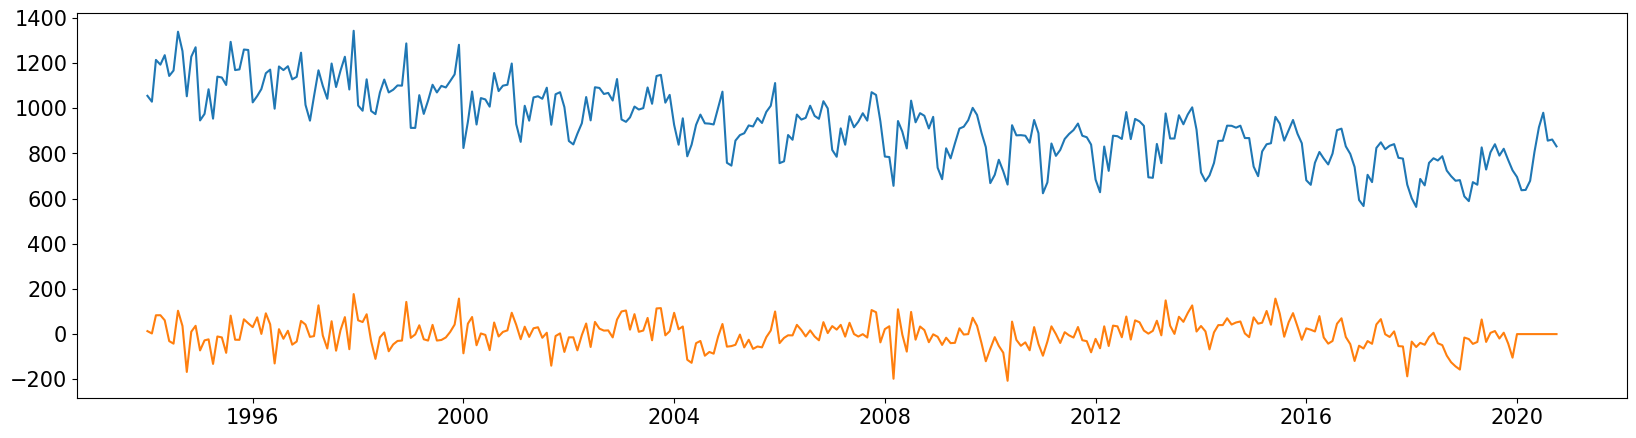

In [24]:
res_data = data - betas
res_data = res_data.reshape(-1)
res_data = np.concatenate((res_data, np.zeros(10)), axis=None)

plt.figure(figsize=(20, 5))
plt.plot(dataset['indice_tiempo'], dataset['vino'], label='Observación')
plt.plot(dataset['indice_tiempo'], res_data, label='Residuo')

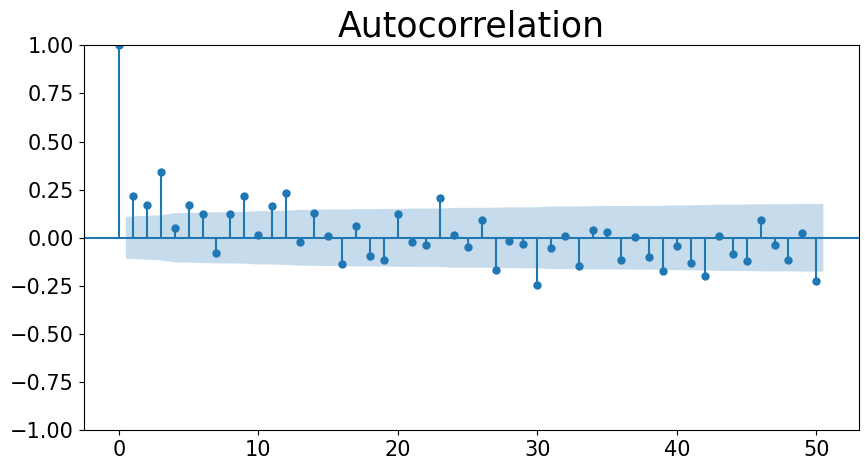

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(res_data, lags=50, ax=ax)
plt.show()

Los coeficientes caen en la zona donde son considerados nulos pero aún no se puede determinar que la serie resultante sea estacionaria.

### Tests para determinar estacionariedad

Se va a trabajar con la serie a la cual se le elimina la tendecia lineal calculada por cuadrados mínimos.

#### Test de Dickey-Fuller

In [26]:
from statsmodels.tsa.stattools import adfuller, kpss
serie = residuo
time = dataset['indice_tiempo']


dftest = adfuller(serie)
dfoutput = pd.Series(
    dftest[0:4],
    index=["Estadístico",
        "p-valor",
        "# Lags usados",
        "# Observaciones usadas",
    ],
)
for key, value in dftest[4].items():
    dfoutput["Valor del umbral (%s)" % key] = value
print(dfoutput)

Estadístico                -4.318932
p-valor                     0.000412
# Lags usados              17.000000
# Observaciones usadas    304.000000
Valor del umbral (1%)      -3.452045
Valor del umbral (5%)      -2.871095
Valor del umbral (10%)     -2.571861
dtype: float64


El estadístico es menor que los 3 umbrales, por lo tanto puedo rechazar la hipótesis nula. Por otro lado, el p-valor es muy chico.  
Según este test la serie diferenciada es ESTACIONARIA.

#### Test KPSS

In [27]:
kpsstest = kpss(serie)
kpss_output = pd.Series(
    kpsstest[0:3], index=["Estadístico", "p-valor", "Lags usados"]
)
for key, value in kpsstest[3].items():
    kpss_output["Valor del umbrarl (%s)" % key] = value
print(kpss_output)

Estadístico                 0.040966
p-valor                     0.100000
Lags usados                 7.000000
Valor del umbrarl (10%)     0.347000
Valor del umbrarl (5%)      0.463000
Valor del umbrarl (2.5%)    0.574000
Valor del umbrarl (1%)      0.739000
dtype: float64


/tmp/ipykernel_67778/1597251960.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(serie)


En este caso el p-valor no es significantemente chico por lo que no puedo rechazar el test, puedo asumir entonces que la serie es ESTACIONARIA.

Ambos test dan indicio que la serie es ESTACIONARIA.

In [28]:
serie_training = serie[:290]
time_training = time[:290]
serie_test = serie[290:]
time_test = time[290:]

### Modelo ARIMA
Bajo la afirmación que {Yt} sigue un modelo ARIMA si  $W_t=\nabla^d Y_t$  es un proceso ARMA(p,q) estacionario, se testeará la serie para ver si es posible modelarla con este modelo.  

Basado en los test de DF Y KPSS inferimos que la serie ya es estacionaria sin diferenciar. Observando una vez más los graficos de autocorrelación y autocorrelación parcial determido los parametros p y q.

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

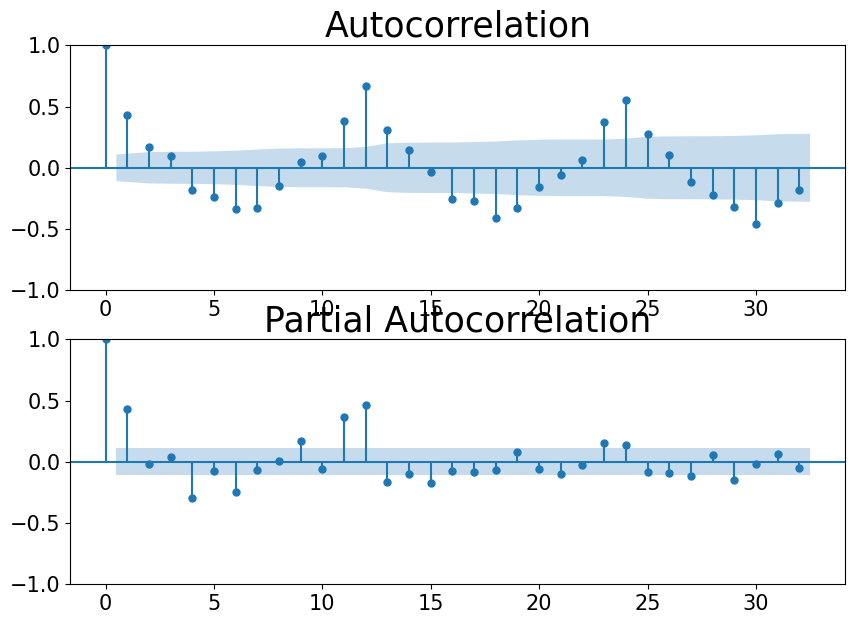

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10,7))
a = plot_acf(np.array(serie), ax=ax[0], lags=32)
a = plot_pacf(np.array(serie), ax=ax[1], lags=32)

Es evidente la componente seasonal, sin embargo nos quedaremos con las primeras componentes para estimar p y q.

d = 0 ya que no es necesario la diferenciación ya que la serie transformada ya vimos era estacionaria.

In [108]:
p = 1
q = 2
d = 0

model = ARIMA(serie, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   vino   No. Observations:                  322
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1900.638
Date:                Sat, 27 Apr 2024   AIC                           3811.276
Time:                        07:46:21   BIC                           3830.148
Sample:                             0   HQIC                          3818.810
                                - 322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      1.698     -0.000      1.000      -3.329       3.328
ar.L1          0.9587      0.036     26.419      0.000       0.888       1.030
ma.L1         -0.5209      0.605     -0.862      0.3

In [109]:
print(type(model_fit))
print(len(serie_test))

<class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
32


In [110]:
y_hat = model_fit.predict(0,321)
testScore = np.sqrt(mean_squared_error(serie, y_hat))
print('Score: %.2f RMSE' % (testScore))

y_hat = model_fit.predict(290,322)
testScore = np.sqrt(mean_squared_error(serie[290:], y_hat[0:32]))
print('Test Score: %.2f RMSE' % (testScore))

Score: 88.60 RMSE
Test Score: 73.08 RMSE


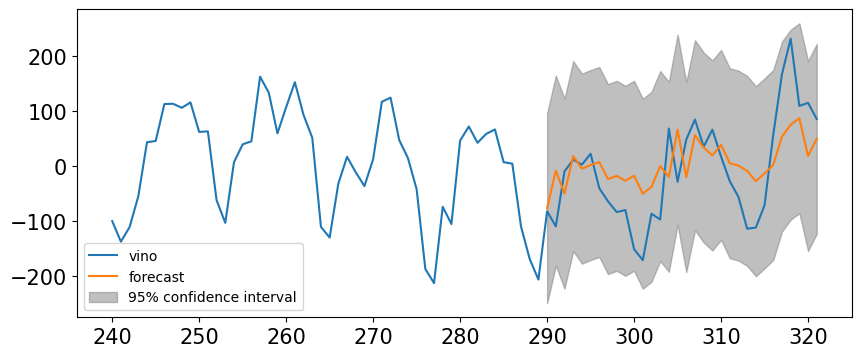

In [111]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = serie.loc[240:].plot()
fig = plot_predict(model_fit, start=290, end=321, ax=ax)

### Modelo SARIMA

Para estimar los parametros seasonal, usare la diferenciacion en 12.

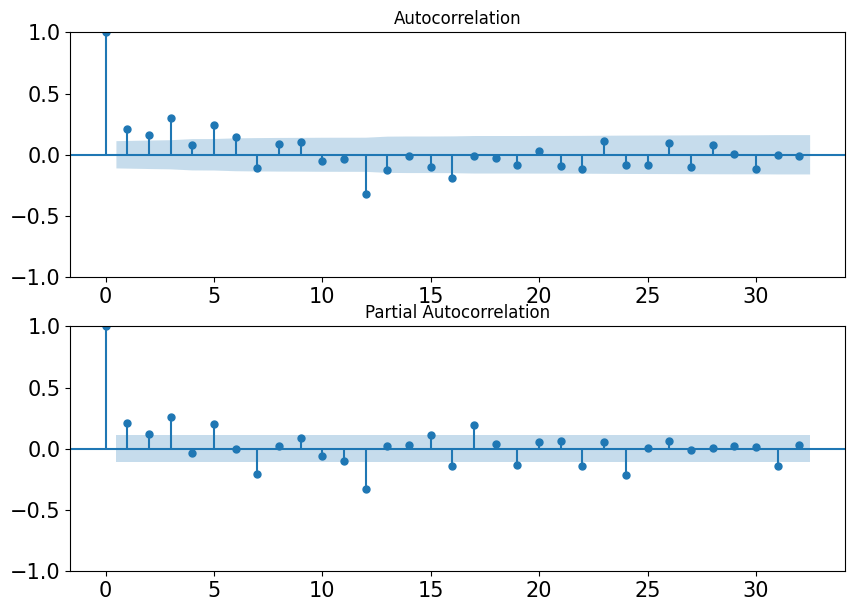

In [112]:
diff = serie.diff(12).dropna()

fig, ax = plt.subplots(2, 1, figsize=(10,7))
a = plot_acf(np.array(diff), ax=ax[0], lags=32)
a = plot_pacf(np.array(diff), ax=ax[1], lags=32)

In [113]:
p = 1
d = 0
q = 2

P = 3
D = 1 
Q = 3  
S = 12 

model = ARIMA(serie, order=(p,d,q), seasonal_order=(P,D,Q,S))
model_fit = model.fit()

print(model_fit.summary())

/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                         
Dep. Variable:                                     vino   No. Observations:                  322
Model:             ARIMA(1, 0, 2)x(3, 1, [1, 2, 3], 12)   Log Likelihood               -1700.961
Date:                                  Sat, 27 Apr 2024   AIC                           3421.922
Time:                                          07:47:09   BIC                           3459.288
Sample:                                               0   HQIC                          3436.860
                                                  - 322                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8787      0.080     11.049      0.000       0.723

In [114]:
y_hat = model_fit.predict(0,321)
testScore = np.sqrt(mean_squared_error(serie, y_hat))
print('Score: %.2f RMSE' % (testScore))

y_hat = model_fit.predict(290,322)
testScore = np.sqrt(mean_squared_error(serie[290:], y_hat[0:32]))
print('Test Score: %.2f RMSE' % (testScore))

Score: 61.09 RMSE
Test Score: 58.90 RMSE


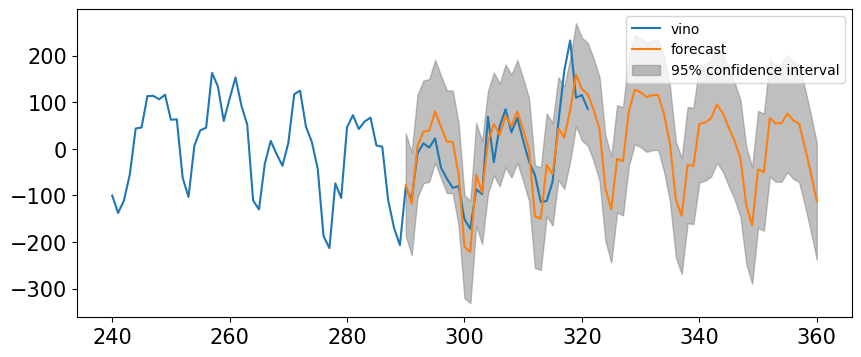

In [115]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = serie.loc[240:].plot()
fig = plot_predict(model_fit, start=290, end=360, ax=ax)

<bound method Figure.set of <Figure size 1000x800 with 4 Axes>>

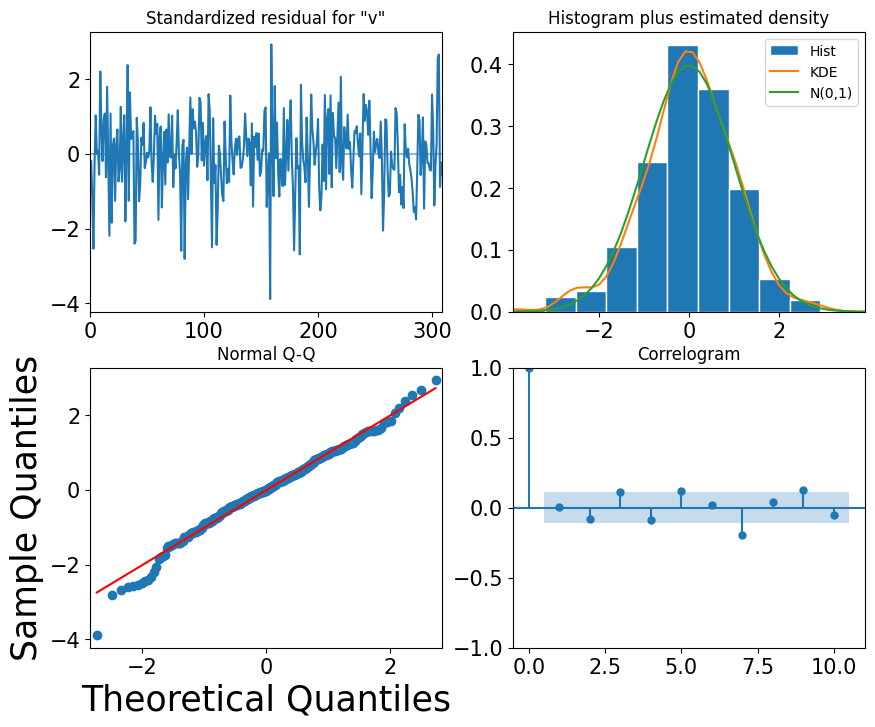

In [37]:
plt.rc('font', size=10)
plt.rc('axes', titlesize=12)
fig = model_fit.plot_diagnostics(figsize=(10,8))
fig.set

In [56]:
from itertools import product

# Set parameter range
p = range(1,4)
q = range(1,4)
d = range(0,2)
s = [12]

pdq = list(product(p, d, q))
seasonal_pdq = list(product(p, d, q, s))
# Create SARIMA model for each order and seasonal order
aics = []
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = ARIMA(serie, order=order, seasonal_order=seasonal_order)
            results = model.fit()
            if results.llf != 0:
                aics.append((order, seasonal_order, results.aic))
        except:
            print('SARIMA{},{} - Skipped'.format(order, seasonal_order))

# Check for smallest AIC
aics.sort(key=lambda x: x[2])

/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 

SARIMA(1, 1, 1),(2, 0, 1, 12) - Skipped
SARIMA(1, 1, 1),(2, 0, 3, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anacond

SARIMA(1, 1, 2),(3, 0, 2, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anacond

SARIMA(2, 0, 1),(3, 0, 3, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-statio

SARIMA(2, 0, 2),(1, 0, 1, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-statio

SARIMA(2, 0, 2),(2, 0, 1, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

SARIMA(2, 0, 3),(3, 0, 1, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1),(1, 0, 1, 12) - Skipped
SARIMA(2, 1, 1),(1, 0, 2, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anacond

SARIMA(2, 1, 3),(2, 0, 1, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

SARIMA(3, 0, 2),(2, 0, 1, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

SARIMA(3, 0, 3),(3, 0, 2, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1),(1, 0, 1, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1),(3, 0, 2, 12) - Skipped
SARIMA(3, 1, 1),(3, 0, 3, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

SARIMA(3, 1, 2),(1, 0, 1, 12) - Skipped


/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

In [58]:
print(aics)

[((1, 1, 3), (3, 0, 2, 12), 371.2991212300049), ((2, 1, 3), (1, 1, 1, 12), 3385.4646623187446), ((2, 1, 3), (1, 1, 2, 12), 3386.0797417231424), ((3, 1, 3), (1, 1, 2, 12), 3386.389141505694), ((3, 1, 3), (1, 1, 1, 12), 3386.950776718704), ((2, 1, 3), (1, 1, 3, 12), 3389.698895671918), ((3, 1, 3), (2, 1, 1, 12), 3390.9849505752363), ((2, 1, 3), (3, 1, 2, 12), 3391.8672369537217), ((2, 1, 3), (2, 1, 3, 12), 3391.907551294449), ((3, 1, 3), (1, 1, 3, 12), 3392.4182572419786), ((2, 1, 3), (2, 1, 1, 12), 3392.52814131342), ((3, 1, 3), (3, 1, 2, 12), 3395.257795961633), ((3, 1, 1), (3, 1, 3, 12), 3395.9060559375434), ((3, 1, 1), (2, 1, 3, 12), 3397.197652339467), ((3, 1, 2), (2, 1, 3, 12), 3397.849651769093), ((1, 0, 1), (2, 1, 3, 12), 3399.077240794325), ((1, 0, 3), (2, 1, 3, 12), 3399.528005413366), ((3, 0, 3), (1, 1, 1, 12), 3399.706509615884), ((3, 0, 2), (2, 1, 3, 12), 3399.838719132114), ((3, 0, 1), (2, 1, 3, 12), 3401.3728535734836), ((3, 0, 3), (1, 1, 2, 12), 3401.9056195441153), ((3, 

In [118]:
p = 2
d = 1
q = 3

P = 1
D = 1 
Q = 2  
S = 12 

model = ARIMA(serie, order=(p,d,q), seasonal_order=(P,D,Q,S))
model_fit = model.fit()

print(model_fit.summary())

/home/sergio/anaconda3/envs/st_p38/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                       
Dep. Variable:                                  vino   No. Observations:                  322
Model:             ARIMA(2, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -1684.040
Date:                               Sat, 27 Apr 2024   AIC                           3386.080
Time:                                       07:48:52   BIC                           3419.680
Sample:                                            0   HQIC                          3399.513
                                               - 322                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1492      0.003   -344.172      0.000      -1.156      -1.143
ar.L2      

In [120]:
y_hat = model_fit.predict(0,321)
testScore = np.sqrt(mean_squared_error(serie, y_hat))
print('Score: %.2f RMSE' % (testScore))

y_hat = model_fit.predict(290,321)
testScore = np.sqrt(mean_squared_error(serie[290:], y_hat))
print('Test Score: %.2f RMSE' % (testScore))

Score: 62.10 RMSE
Test Score: 56.25 RMSE


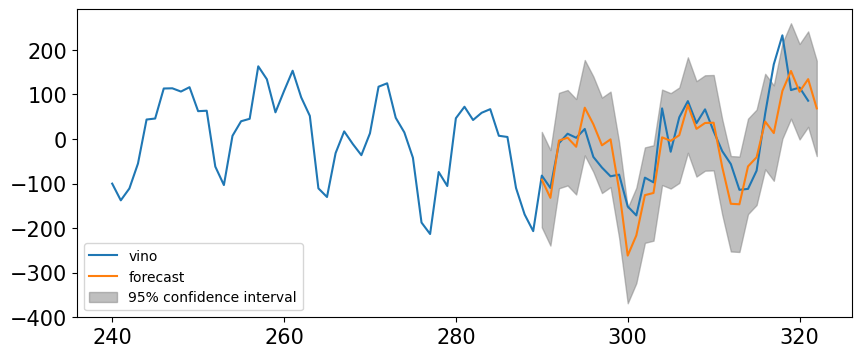

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = serie.loc[240:].plot()
#ax = serie.plot()
fig = plot_predict(model_fit, start=290, end=322, ax=ax)

<bound method Figure.set of <Figure size 1000x800 with 4 Axes>>

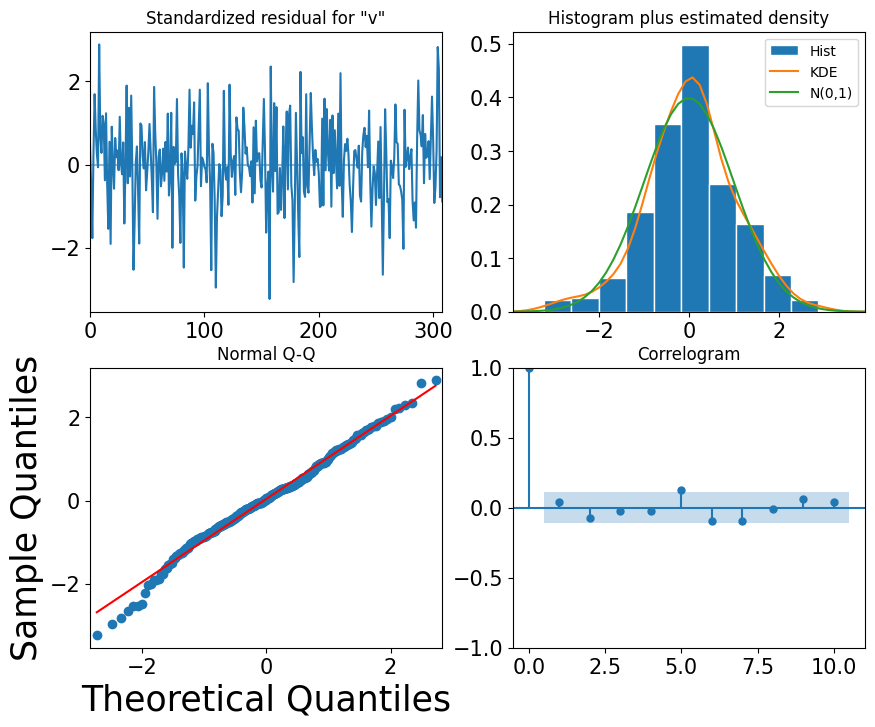

In [42]:
plt.rc('font', size=10)
plt.rc('axes', titlesize=12)

fig = model_fit.plot_diagnostics(figsize=(10,8))
fig.set

----

In [43]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, GRU, Dense, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# fix random seed for reproducibility
tf.random.set_seed(7)

2024-04-26 20:21:24.613231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 20:21:25.423926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [44]:
print(serie.info())
print(time.info())

<class 'pandas.core.series.Series'>
Index: 322 entries, 0 to 321
Series name: vino
Non-Null Count  Dtype  
--------------  -----  
322 non-null    float64
dtypes: float64(1)
memory usage: 13.1 KB
None
<class 'pandas.core.series.Series'>
Index: 322 entries, 0 to 321
Series name: indice_tiempo
Non-Null Count  Dtype         
--------------  -----         
322 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 13.1 KB
None


### Normalizar los datos


In [45]:
print (np.array(serie).shape)

# reshape porque el scaler requiere esa forma.
np_serie = np.array(serie).reshape(-1,1)
print (np_serie.shape)

scaler = MinMaxScaler(feature_range=(0, 1))

np_serie = scaler.fit_transform(np_serie)
# El flatten es para volver los datos a la forma original.
np_serie = np_serie.flatten()
print (np_serie.shape)

(322,)
(322, 1)
(322,)


### Ventanas deslizantes y salida

In [46]:
#Función para obtener el target de cada grupo de elementos.
def get_feature_target(data,cant_element):
    end_len = len(data)
    X = []
    y = []
    steps = cant_element
    for i in range(steps, end_len):
        X.append(data[i - steps:i])
        y.append(data[i])
    X, y = np.array(X), np.array(y)
    X = np.expand_dims(X, axis=2)
    return X ,y

In [47]:
#Separar el X (grupo de elementos) del y (target).
# cant_element es el tamaño de la ventana
cant_element = 24
X, y = get_feature_target(np_serie,cant_element)

print(len(np_serie))
print(X.shape)
print(y.shape)

322
(298, 24, 1)
(298,)


### Separar los datos en train y test

In [48]:
# Se hace el split en train y test con shuffle=false para que sea secuencial.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
input_shape = X_train[0].shape
print (input_shape)

(24, 1)


Red LSTM

In [49]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(input_shape), activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(),loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-04-26 20:21:27.760108: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [50]:
hist = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=67)

Epoch 1/100
4/4 [==============================] - 1s 87ms/step - loss: 0.1862 - val_loss: 0.1483
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.1363 - val_loss: 0.0983
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0913 - val_loss: 0.0565
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0527 - val_loss: 0.0383
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0435 - val_loss: 0.0616
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0496 - val_loss: 0.0437
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0398 - val_loss: 0.0375
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0415 - val_loss: 0.0385
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0426 - val_loss: 0.0382
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0372
Epoch 11/100
4/4 [=

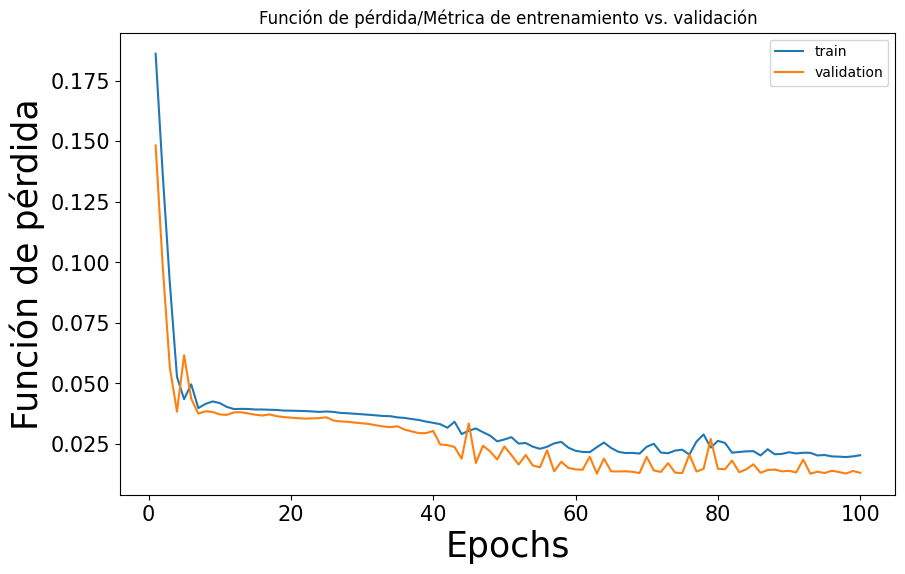

In [51]:
epoch_count = range(1, len(hist.history['loss']) + 1)
fig, ax = plt.subplots(figsize=(10, 6))
plt.rc('font', size=10)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.plot(epoch_count, hist.history['loss'], label='train')
plt.plot(epoch_count, hist.history['val_loss'], label='validation')
plt.legend()
plt.title ("Función de pérdida/Métrica de entrenamiento vs. validación")
plt.xlabel("Epochs")
plt.ylabel("Función de pérdida")
plt.show()

In [52]:
mse_evaluate=model.evaluate(X_test, y_test)
print (mse_evaluate)

1/1 [==============================] - 0s 24ms/step - loss: 0.0196
0.019599875435233116


In [53]:
# Predecir solo con los datos.

# Predecir train.
y_hat_train = model.predict(X_train)
print(y_hat_train.shape)

# Predecir test.
y_hat = model.predict(X_test)
print(y_hat.shape)

9/9 [==============================] - 0s 3ms/step
(268, 1)
1/1 [==============================] - 0s 17ms/step
(30, 1)


In [54]:
# invert predictions
trainPredict = scaler.inverse_transform(y_hat_train)
trainY = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()

testPredict = scaler.inverse_transform(y_hat)
testY = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 66.75 RMSE
Test Score: 69.33 RMSE


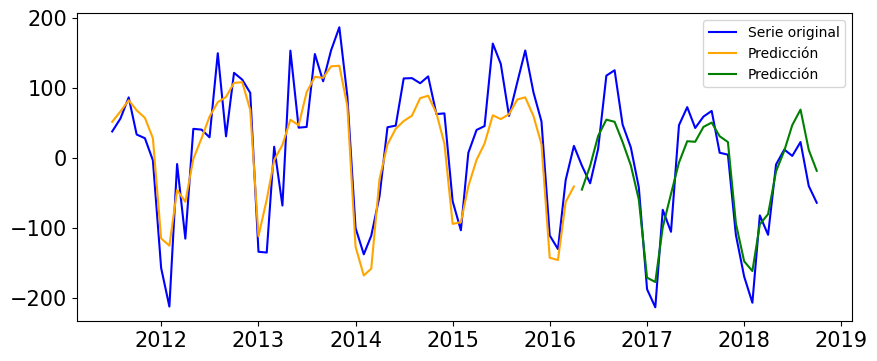

In [55]:
# Graficar datos de prueba y predicción.

fig, ax = plt.subplots(figsize=(10, 4))
plt.rc('font', size=10)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=8)
plt.plot(time[210:len(time)-24], serie[210:len(time)-24], color="blue",label="Serie original")
plt.plot(time[210:len(trainPredict)],trainPredict[210:], color="orange",label="Predicción")
plt.plot(time[len(trainPredict):len(trainPredict)+len(testPredict)],testPredict, color="green",label="Predicción")
plt.legend()
plt.show()

----

### Analisis espectral

In [57]:
from scipy import signal

322


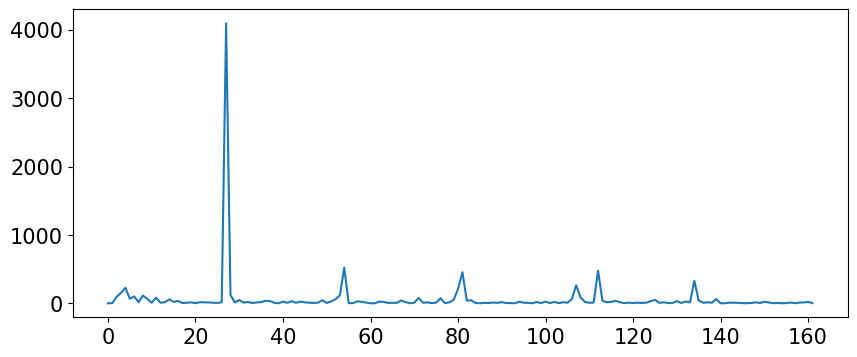

In [83]:
fig, ax = plt.subplots(figsize=(10, 4))
print(len(serie))
G, Pyy_den = signal.periodogram(serie,322)
plt.plot(G, Pyy_den) 
plt.show()

322


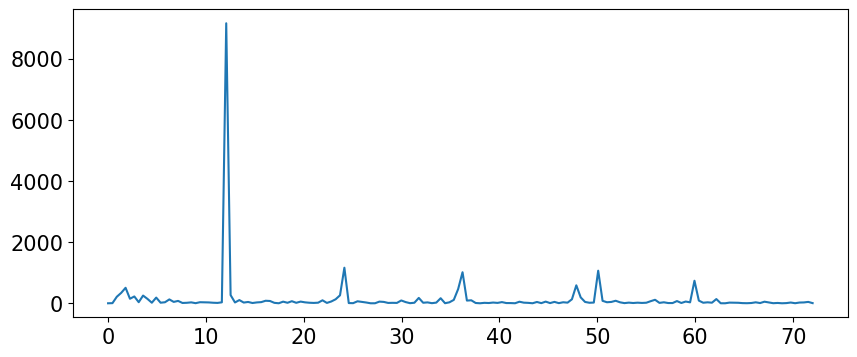

In [81]:
fig, ax = plt.subplots(figsize=(10, 4))
print(len(serie))
G, Pyy_den = signal.periodogram(serie,144)
plt.plot(G, Pyy_den) 
plt.show()